In [1]:
%load_ext autoreload
%autoreload 2

Data augmentation is a key technique used in computer vision. It helps neural networks to learn useful representations and generalize better to unseen samples. In this tutorial we show how to do data augmentation in Pytorch EO.

## Classification

Data augmentation for classification is a special case, since only the input has to be transformed without changing the outputs. For this case we provide `torchvision` transforms by default.

In [2]:
from pytorch_eo.datasets.eurosat import EuroSATRGB

ds = EuroSATRGB()
ds.setup()

In [3]:
import matplotlib.pyplot as plt

def plot_sample(ds, ix):
    fig = plt.figure(figsize=(10, 10))
    for i in range(5):
        img, label = ds.ds[ix]
        ax = plt.subplot(1, 5, i + 1)
        ax.imshow(img.permute(1,2,0))
        ax.set_title(ds.classes[label.item()])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

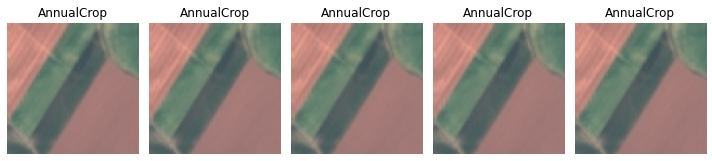

In [4]:
plot_sample(ds, 0)

In [5]:
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip

trans = Compose([
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5)
])

ds = EuroSATRGB(trans=trans)
ds.setup()

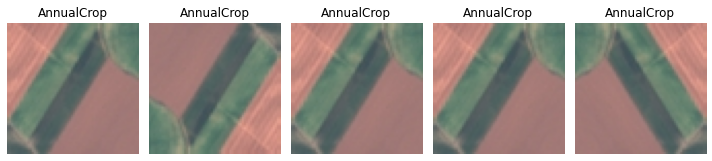

In [6]:
plot_sample(ds, 0)

Torchvision transforms can run in batch mode in the gpu (which can be faster). To do so, put the transforms in your model. The same transform is applied to all the batch.

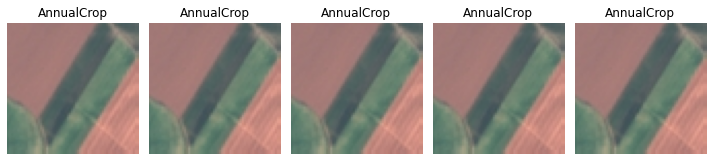

In [7]:
import torch
from pytorch_eo.tasks.BaseTask import BaseTask

model = torch.nn.Sequential(
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5)
)

task = BaseTask(model)

# create a batch with the same image
img, label = ds.ds[0]
imgs = torch.stack(5*[img])
output = task(imgs)

fig = plt.figure(figsize=(10, 10))
for i, img in enumerate(imgs):
    ax = plt.subplot(1, 5, i + 1)
    ax.imshow(img.permute(1,2,0))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

You may want to use third party libraries, like `augmentations` or `kornia`. To do so, you have to build your own datasets and override the `_trans_image` function.

In [26]:
from pytorch_eo.utils.datasets import ClassificationDataset

class MyDataset(ClassificationDataset):
    def __init__(self, images, labels, trans):
        super().__init__(images, labels, trans)

    def _trans_image(self, img):
        # using albumentations (requires numpy arrays with channels last)
        if self.trans:  
            img = img.permute(1,2,0).numpy() # H, W, C
            img_trans = self.trans(image=img)['image']
            return torch.from_numpy(img_trans).permute(2,0,1) # C, H, W
        return img

In [27]:
from skimage import io

# can be faster

class MyFasterDataset(ClassificationDataset):
    def __init__(self, images, labels, trans):
        super().__init__(images, labels, trans)

    def _read_image(self, img):
        return io.imread(img)

    def _trans_image(self, img):
        # using albumentations (requires numpy arrays with channels last)
        if self.trans:  
            img_trans = self.trans(image=img)['image']
            return img_trans
        return img

    def _to_tensor(self, img):
        return torch.from_numpy(img).permute(2,0,1)

In [33]:
import albumentations as A

trans = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

ds = EuroSATRGB(trans=trans, dataset=MyFasterDataset)
ds.setup()

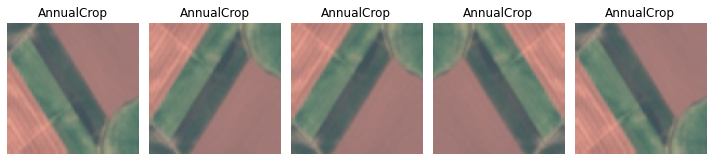

In [37]:
plot_sample(ds, 0)

## Other tasks

Torchvision support for augmenting bounding boxes, segmentation masks, keypoints, ... is limited. For that, `albumentations` is a great alternative.

In [38]:
# TODO: example